In [49]:

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

import json



In [50]:
# import os
# import tensorflow_datasets as tfds
# from PIL import Image
# print(tf.__version__)
# input_shape = (32, 32, 3)

inputFolder = "data_20/"

# labelsJson = None
# with open(inputFolder+'labels.json') as json_file:
#     labelsJson = json.load(json_file)

# labelsJson=list(map(lambda x: np.asarray(x), labelsJson))

# images=[]
# for filename in os.listdir(inputFolder+"images"):
#     images.append(np.array(Image.open(
#         inputFolder+"images/"+filename).convert("RGB")).flatten())
# images = images

# train_ds = list(zip(images[0:4], labelsJson[0:4]))
# test_ds = list(zip(images[5:], labelsJson[5:]))
# #print(train_ds, test_ds, "train image samples")
print(tf.__version__)
input_shape = (32, 32, 3)

labelsJson = None
with open(inputFolder+'labels.json') as json_file:
    labelsJson = json.load(json_file)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=inputFolder,
    labels=labelsJson,
    validation_split=0.3,
    subset="training",
    shuffle=False,
    seed=123,
    image_size=(32, 32),
    batch_size=1)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=inputFolder,
    labels=labelsJson,
    validation_split=0.3,
    subset="validation",
    shuffle=False,
    seed=123,
    image_size=(32, 32),
    batch_size=1)
print(train_ds, test_ds, "train image samples")


2.5.0
Found 18 files belonging to 1 classes.
Using 13 files for training.
Found 18 files belonging to 1 classes.
Using 5 files for validation.
<BatchDataset shapes: ((None, 32, 32, 3), (None, 5)), types: (tf.float32, tf.float32)> <BatchDataset shapes: ((None, 32, 32, 3), (None, 5)), types: (tf.float32, tf.int32)> train image samples


(32, 32, 3)


In [51]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(20, activation="relu"),
        layers.Dense(10, activation="relu"),
        layers.Dense(5, activation="linear"),
    ]
)

model.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 2304)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 20)               

In [52]:
epochs = 20
batch_size=1

model.compile(loss="mean_squared_error",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

history = model.fit(
    train_ds,
    validation_data=test_ds,
    #x=np.expand_dims(images, axis=0),
    #y=np.expand_dims(labelsJson, axis=0),
    batch_size=batch_size,
    epochs=epochs,
)

Epoch 1/20
13/13 [==============================] - 1s 19ms/step - loss: 426.7803 - val_loss: 12.2178
Epoch 2/20
13/13 [==============================] - 0s 11ms/step - loss: 127.4398 - val_loss: 20.9158
Epoch 3/20
13/13 [==============================] - 0s 10ms/step - loss: 25.2630 - val_loss: 16.4188
Epoch 4/20
13/13 [==============================] - 0s 10ms/step - loss: 22.5342 - val_loss: 5.4911
Epoch 5/20
13/13 [==============================] - 0s 10ms/step - loss: 13.3939 - val_loss: 10.5379
Epoch 6/20
13/13 [==============================] - 0s 11ms/step - loss: 5.5501 - val_loss: 1.4657
Epoch 7/20
13/13 [==============================] - 0s 10ms/step - loss: 8.4153 - val_loss: 1.4546
Epoch 8/20
13/13 [==============================] - 0s 10ms/step - loss: 4.0806 - val_loss: 1.7358
Epoch 9/20
13/13 [==============================] - 0s 9ms/step - loss: 7.1830 - val_loss: 2.0814
Epoch 10/20
13/13 [==============================] - 0s 9ms/step - loss: 1.4199 - val_loss: 1.6591


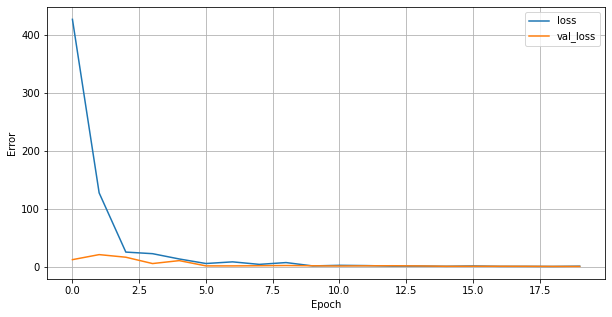

In [53]:

plt.rcParams['figure.figsize'] = [10, 5]
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)


plot_loss(history)


In [54]:
score = model.evaluate(test_ds, verbose=0)
print("Test loss:", score)
#print("Test accuracy:", score[1])


Test loss: 0.502207338809967


In [55]:
#print(train_ds[0])
#plt.imshow(images[x].numpy().astype("uint8"))
#plt.title(
#    "{:.4f} / {:.4f}".format(labels[x].numpy()[3], model.predict(images)[0][0]))
#plt.axis("off")


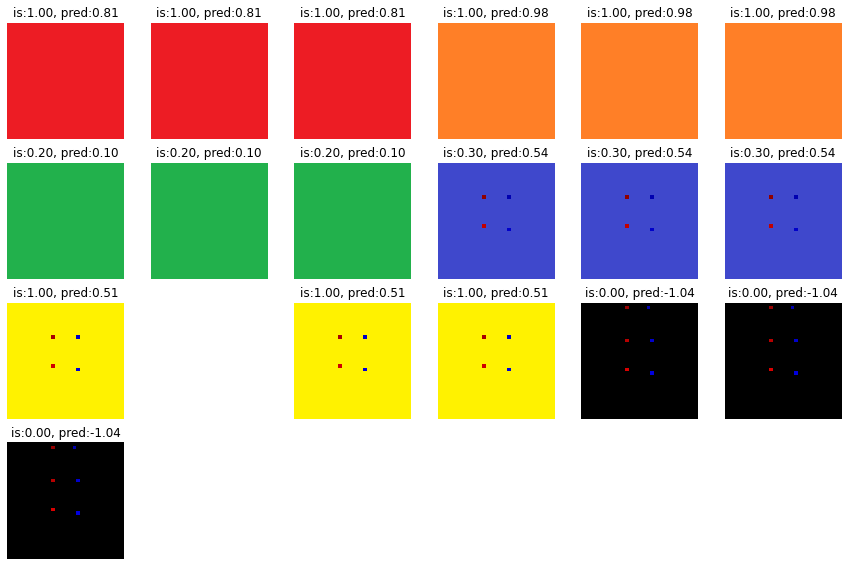

In [56]:
# plt.rcParams['figure.figsize'] = [15, 15]
# for i in range(49):
#     plt.subplot(7, 7, i+1)
#     plt.imshow(x_test[i].reshape(28, 28), cmap='gray', interpolation='none')
#     plt.axis('off')
#     plt.title("{}, is: {:.2f}".format(
#         y_test[i], model.predict(x_test[i:i+1])[0][0],2))

plt.rcParams['figure.figsize'] = [15, 15]
i=0
for images, labels in train_ds:
    i=i+1
    ax = plt.subplot(6, 6, i)
    plt.imshow(images[0].numpy().astype("uint8"))
    plt.title(
        "is:{:.2f}, pred:{:.2f}".format(labels[0].numpy()[3], model.predict(images)[0][0]))
    plt.axis("off")
i = i+1
for images, labels in test_ds:
    i = i+1
    ax = plt.subplot(6, 6, i)
    plt.imshow(images[0].numpy().astype("uint8"))
    plt.title(
        "is:{:.2f}, pred:{:.2f}".format(labels[0].numpy()[3], model.predict(images)[0][0]))
    plt.axis("off")
